# Import

In [1]:
import json 
from pathlib import Path
import pandas as pd
import shap
from umap import UMAP
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


helper function

In [2]:
PROJECT_ROOT_DIR = Path.cwd().parent.parent

def get_manual_selected_features_data(match_played=2, minutes_played=90) -> pd.DataFrame:
    print("=== Manual selected features ===")
    # define dimensions
    dimensions = ["defending","possession", "passing", "shooting", "goal_keeping"]
    
    # load standard stats
    df_standard_stats = pd.read_csv(f"{PROJECT_ROOT_DIR}/data/new_approach/standard_stats_all_final.csv",dtype={"player_id":"int32"}) # load_standard_stats(unique_index=True)
    df = df_standard_stats[["player_id", "position_level_0", "position_level_1", "position_level_2", "match_played", "minutes_played"]].copy()
    
    # load and merge all dimensions
    for dim in dimensions:
        # load
        df_dimension = pd.read_csv(f"{PROJECT_ROOT_DIR}/data/new_approach/{dim}_ex.csv",dtype={"player_id":"int32"})
        # print(f"Full dimension '{dim}' shape {df_dimension.shape}")

        # merge and update base df
        df = pd.merge(
            left=df,
            right=df_dimension.loc[:, df_dimension.columns != "player"],
            left_on="player_id", 
            right_on="player_id",
            how="left"
        )
    # filter rows
    # print(f"Apply filters: match_played={match_played} , minutes_player={minutes_played}")
    df_filtered = df.loc[(df["match_played"]>=match_played) & (df["minutes_played"]>=minutes_played), : ].copy()#filter_df(df, match_played=match_played, minutes_played=minutes_played)

    # keep only manually selected columns
    columns_to_keep = ["player_id", "position_level_0", "position_level_1","position_level_2"]
    for dim in dimensions:
        path = f"{PROJECT_ROOT_DIR}/experiment_results/feature_selection_manual/manual_{dim}.json"
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        columns_to_keep.extend(data["selected_columns"])
    print(f"Number of selected manual selected features: {len(columns_to_keep)}")
    df_filtered = df_filtered.loc[:, columns_to_keep]
    print("Loaded df shape:", df_filtered.shape)

    return df_filtered

def get_data(target:str = "position_level_0", match_played=2, minutes_played=90):
    """Merges all dimensions and applies filters"""
    print("=== Automated selected features ===")
    # vars
    dimensions = ["defending","possession", "passing", "shooting", "goal_keeping"]
    df_standard_stats = pd.read_csv("../../data/new_approach/standard_stats_all_final.csv",dtype={"player_id":"int32"}) # load_standard_stats(unique_index=True)

    # Merge all dimensions
    df = df_standard_stats[["player_id", "position_level_0", "position_level_1","position_level_2", "match_played", "minutes_played"]].copy()
    for dim in dimensions:
        # load
        df_dimension = pd.read_csv(f"../../data/new_approach/{dim}_ex.csv",dtype={"player_id":"int32"})
        # print(f"Dim {dim} shape{df_dimension.shape}")
        # print("Columns:", df_dimension.columns.tolist())
        # merge and update base df
        df = pd.merge(
            left=df,
            right=df_dimension.loc[:, df_dimension.columns != "player"],
            left_on="player_id", 
            right_on="player_id",
            how="left"
        )
    # print(f"Merge shape: {df.shape}")

    # filter rows
    # print(f"Apply filters: match_played={match_played} , minutes_player={minutes_played}")
    df_filtered = df.loc[(df["match_played"]>=match_played) & (df["minutes_played"]>=minutes_played), : ].copy()#filter_df(df, match_played=match_played, minutes_played=minutes_played)

    # filter columns
    config_1_columns = ["player_id", "position_level_0", "position_level_1","position_level_2"]
    config_2_columns = ["player_id", "position_level_0", "position_level_1","position_level_2"]
    config_3_columns = ["player_id", "position_level_0", "position_level_1","position_level_2"]

    # load and merge selected features
    for dim in dimensions:
        path = f"../../experiment_results/feature_selection_{target}/automated_{dim}.json"
        # print(f"Load features from: {path}")
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        # print("---")
        # print(dim)
        config_1_columns.extend(data["conf_1"]["selected_columns"])
        #print(data["conf_1"]["selected_columns"])
        config_2_columns.extend(data["conf_2"]["selected_columns"])
        config_3_columns.extend(data["conf_3"]["selected_columns"])
    
    # Optionally remove duplicates if needed
    config_1_columns = list(set(config_1_columns))
    config_2_columns = list(set(config_2_columns))
    config_3_columns = list(set(config_3_columns))

    print("Config 1 columns:", len(config_1_columns))
    print("Config 2 columns:", len(config_2_columns))
    print("Config 3 columns:", len(config_3_columns))

    final_df = df_filtered.loc[:,config_3_columns].copy()
    print("Final df shape:", final_df.shape)

    return final_df

def plot_pca_clusters(transformed_df, target="position_level_0", name=""):
    plt.figure(figsize=(7, 5))
    plt.grid(True, alpha=0.3)
    # Plot each class separately for legend
    for label in transformed_df[target].unique():
        subset = transformed_df[transformed_df[target] == label]
        plt.scatter(subset["PC1"], subset["PC2"], label=label, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA Cluster Scatter Plot - {name}")
    plt.legend(title=target)
    plt.show()


def plot_umap_clusters(transformed_df, target="position_level_0", name=""):
    plt.figure(figsize=(7, 5))
    plt.grid(True, alpha=0.3)
    # Plot each class separately for legend
    for label in transformed_df[target].unique():
        subset = transformed_df[transformed_df[target] == label]
        plt.scatter(subset["UMAP1"], subset["UMAP2"], label=label, alpha=0.7)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"UMAP Cluster Scatter Plot - {name}")
    plt.legend(title=target)
    plt.show()

# Plotting 2d PCA

=== Manual selected features ===
Number of selected manual selected features: 197
Loaded df shape: (2352, 197)


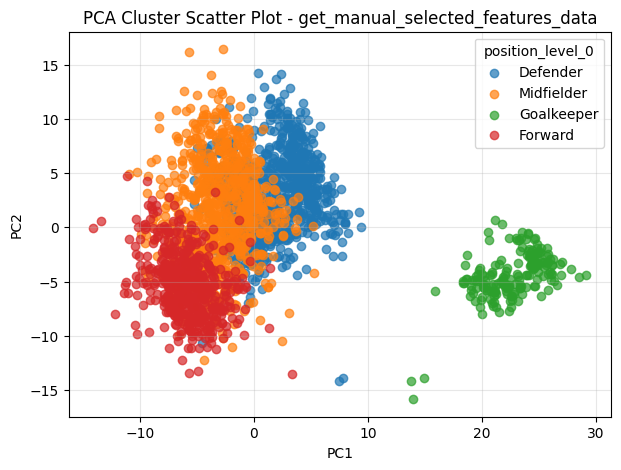

ARI: 0.353897915269361
NMI: 0.4817046361158181
Silhouette Score: 0.43064356829061273
=== Automated selected features ===
Config 1 columns: 73
Config 2 columns: 58
Config 3 columns: 90
Final df shape: (2352, 90)


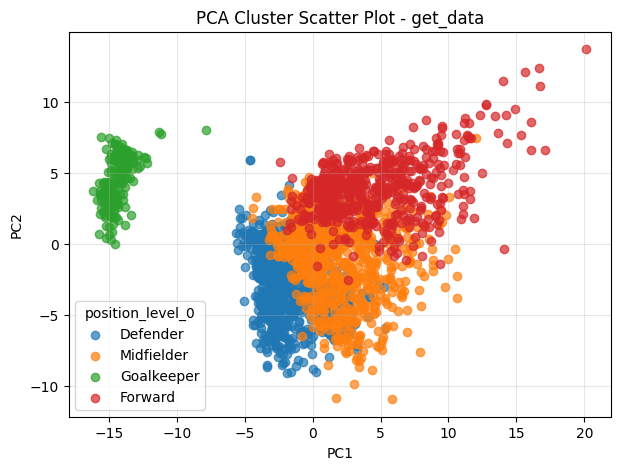

ARI: 0.24785305704022462
NMI: 0.4123821279858487
Silhouette Score: 0.3992924545381605


In [ ]:
data_loading_functions = [get_manual_selected_features_data, get_data]

for load_data in data_loading_functions:
    # load
    df = load_data(match_played=2, minutes_played=90)
    df = df.fillna(0).set_index("player_id")
   
    X = df.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
    y = df["position_level_0"]

    # Define pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),       # standardize features (mean=0, variance=1)
        ("pca", PCA(n_components=2)),       # reduce dimensionality to 2 PCs
    ])

    # Fit pipeline
    X_transformed: np.ndarray = pipe.fit_transform(X, y)
    transformed_df = pd.DataFrame(X_transformed, columns=["PC1", "PC2"], index=df.index)
    transformed_df["position_level_0"] = y
    transformed_df["position_level_1"] = df["position_level_1"]
    transformed_df["position_level_2"] = df["position_level_2"]

    # Plot 
    plot_pca_clusters(transformed_df, target="position_level_0", name=load_data.__name__)


    # Evaluate Cluster
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
    clusters = kmeans.fit_predict(X_transformed)
    print("ARI:", adjusted_rand_score(y, clusters))
    print("NMI:", normalized_mutual_info_score(y, clusters))
    print("Silhouette Score:", silhouette_score(X_transformed, clusters))


# Plotting 2d UMAP

=== Manual selected features ===
Number of selected manual selected features: 197
Loaded df shape: (2352, 197)


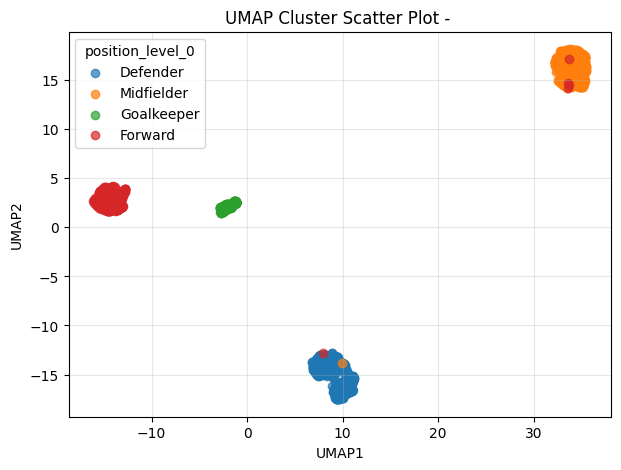

ARI: 0.9893377924472917
NMI: 0.980361523242971
Silhouette Score: 0.9166204
=== Automated selected features ===
Config 1 columns: 73
Config 2 columns: 58
Config 3 columns: 90
Final df shape: (2352, 90)


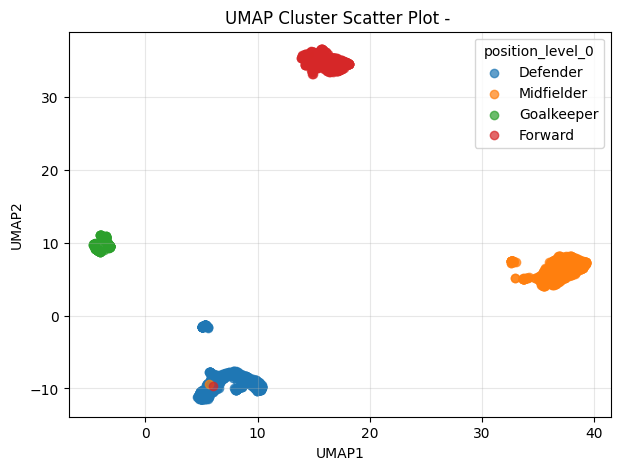

ARI: 0.9927840801691007
NMI: 0.9867646259999184
Silhouette Score: 0.9063509


In [14]:
data_loading_functions = [get_manual_selected_features_data, get_data]

for load_data in data_loading_functions:
    # load
    df = load_data(match_played=2, minutes_played=90)
    df = df.fillna(0).reset_index()
    X = df.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
    y = df["position_level_0"]
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Define pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),       # standardize features (mean=0, variance=1)
        ("umap", UMAP(n_components=2)),       # reduce dimensionality to 2 PCs
    ])

    # Fit pipeline
    X_transformed: np.ndarray = pipe.fit_transform(X, y_encoded)
    transformed_df = pd.DataFrame(X_transformed, columns=["UMAP1", "UMAP2"])
    transformed_df["position_level_0"] = label_encoder.inverse_transform(y_encoded)
    transformed_df["position_level_1"] = df["position_level_1"]
    transformed_df["position_level_2"] = df["position_level_2"]

    # Plot 
    plot_umap_clusters(transformed_df, target="position_level_0")

    # Evaluate Cluster
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
    clusters = kmeans.fit_predict(X_transformed)
    print("ARI:", adjusted_rand_score(y, clusters))
    print("NMI:", normalized_mutual_info_score(y, clusters))
    print("Silhouette Score:", silhouette_score(X_transformed, clusters))

# Plotting 2d UMAP + SHAP

helper function

In [17]:
PROJECT_ROOT_DIR = Path.cwd().parent.parent


=== Manual selected features ===
Number of selected manual selected features: 197
Loaded df shape: (2352, 197)


100%|===================| 9380/9408 [01:51<00:00]        

(2352, 193, 4)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


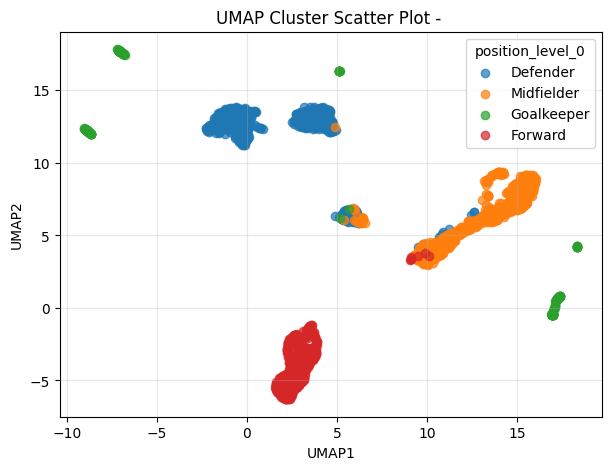

=== Automated selected features ===
Config 1 columns: 73
Config 2 columns: 58
Config 3 columns: 90
Final df shape: (2352, 90)


100%|===================| 9383/9408 [01:56<00:00]        

(2352, 86, 4)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


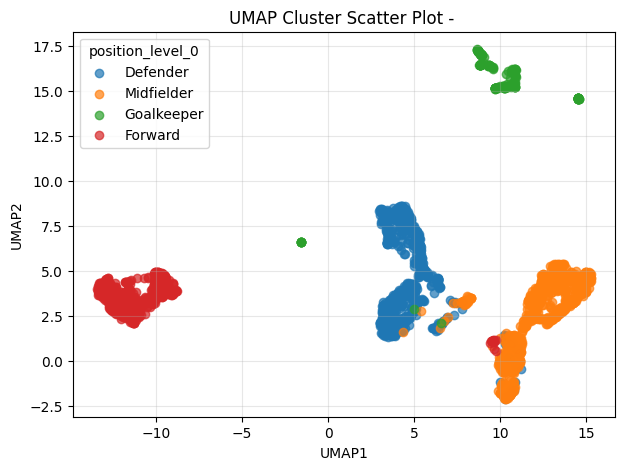

In [4]:
data_loading_functions = [get_manual_selected_features_data, get_data]
shap_df_dic = {}


for load_data in data_loading_functions:
    # === Load Fit Model ===
    # load
    df = load_data(match_played=2, minutes_played=90)
    df = df.fillna(0).set_index("player_id")
    X = df.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
    y = df["position_level_0"]

    # Define pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),       # standardize features (mean=0, variance=1)
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))       # reduce dimensionality to 2 PCs
    ])
    pipe.fit(X, y)
    model = pipe.named_steps['clf']
    scaler = pipe.named_steps['scaler'] 


    # === SHAP ===
    # Create SHAP explainer
    X_scaled = scaler.transform(X)
    explainer = shap.Explainer(model, X_scaled) # would work: training data I provide X_scaled[:10]

    # Compute SHAP values for full data (disable additivity check)
    shap_values = explainer(X_scaled, check_additivity=False)
    print(shap_values.shape)

    # Step 1: Map position labels to class indices
    label_to_index = {label: idx for idx, label in enumerate(model.classes_)}  # e.g., {'Defender': 0, ...}
    true_class_indices = y.map(label_to_index).values  # shape: (3096,)

    # Step 2: Extract SHAP values of the true class for each sample
    # prepare shape and arrays for storage
    n_samples, n_features, n_classes = shap_values.values.shape
    shap_true_class = np.zeros((n_samples, n_features))
    n_samples, n_features, n_classes

    # for each player only consider shap embeddings of the actual true class
    for i in range(n_samples):
        shap_true_class[i] = shap_values.values[i, :, true_class_indices[i]] # (row, column, class)

    # Step 3: Convert to DataFrame
    shap_df = pd.DataFrame(shap_true_class, columns=shap_values.feature_names, index=df.index)
    shap_df["position_level_0"] = df["position_level_0"]
    shap_df["position_level_1"] = df["position_level_1"]
    shap_df["position_level_2"] = df["position_level_2"]
    shap_df_dic[load_data.__name__] = shap_df

    # === UMAP and Plot ===
    X_shap = shap_df.drop(columns=['position_level_0', "position_level_1", "position_level_2"])
    y_shap = shap_df['position_level_0']

    umap_transformer = UMAP(n_components=2, init='random', random_state=42)
    X_transformed = umap_transformer.fit_transform(X_shap)
    transformed_df = pd.DataFrame(X_transformed, columns=["UMAP1", "UMAP2"], index=df.index)
    transformed_df["position_level_0"] = df["position_level_0"]
    transformed_df["position_level_1"] = df["position_level_1"]
    transformed_df["position_level_2"] = df["position_level_2"]

    # Plot 
    plot_umap_clusters(transformed_df, target="position_level_0")


# Within Midfielder Plotting 2d UMAP
sufficient for __defender__ and __forward__ in __aggregation level 1__

In [21]:
umap_transformer = UMAP(n_components=2, init='random', random_state=42)
umap_transformer.fit_transform(X)

c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[ 7.7051907,  5.566743 ],
       [ 7.049082 ,  6.003376 ],
       [ 7.134297 ,  5.7356176],
       ...,
       [ 7.0381293, 23.920984 ],
       [ 6.9930763, 23.966059 ],
       [ 7.0623293, 23.89677  ]], dtype=float32)

=== Automated selected features ===
Config 1 columns: 73
Config 2 columns: 58
Config 3 columns: 90
Final df shape: (2352, 90)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


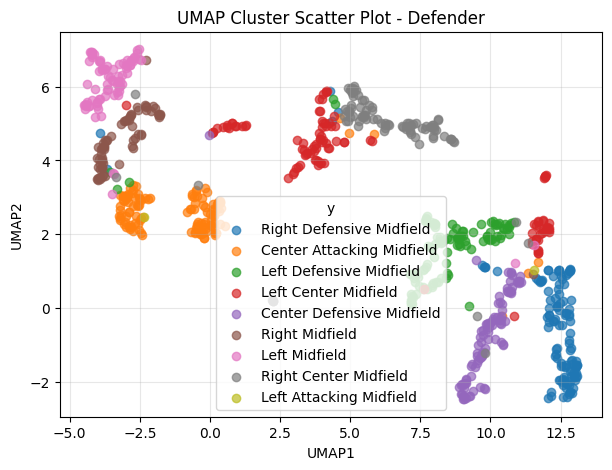

ARI: 0.4812371290593066
NMI: 0.6334269990893706
=== Manual selected features ===
Number of selected manual selected features: 197
Loaded df shape: (2352, 197)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


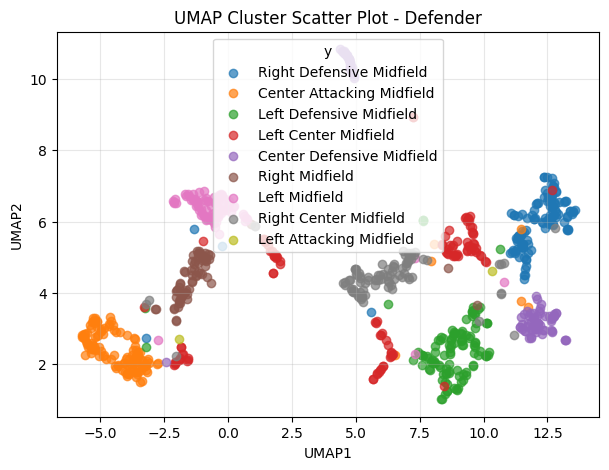

ARI: 0.6009038195143903
NMI: 0.6775609166947364


In [3]:
data_loading_functions = [get_data, get_manual_selected_features_data]


for load_data in data_loading_functions:
    # load
    df = load_data(match_played=2, minutes_played=90)
    df_midfielder = df[df["position_level_0"] == "Midfielder"]
    df_midfielder = df_midfielder.fillna(0).reset_index()

    X = df_midfielder.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
    y = df_midfielder["position_level_2"]
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Define pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),       # standardize features (mean=0, variance=1)
        ("umap", UMAP(n_components=2, init='random', random_state=42)),       # reduce dimensionality to 2 PCs
    ])

    # Fit pipeline
    X_transformed: np.ndarray = pipe.fit_transform(X, y_encoded)
    transformed_df = pd.DataFrame(X_transformed, columns=["UMAP1", "UMAP2"])
    transformed_df["position_level_0"] = df_midfielder["position_level_0"]
    transformed_df["position_level_1"] = df_midfielder["position_level_1"]  # df_midfielder["position_level_1"]
    transformed_df["position_level_2"] = df_midfielder["position_level_2"]
    transformed_df["y"] = label_encoder.inverse_transform(y_encoded)
    # transformed_df = transformed_df[transformed_df["position_level_0"] == "Midfielder"]

    # Plot 
    plot_umap_clusters(transformed_df, target="y", name="Defender")
    
    # Evaluate Cluster
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
    clusters = kmeans.fit_predict(X_transformed)
    print("ARI:", adjusted_rand_score(y, clusters))
    print("NMI:", normalized_mutual_info_score(y, clusters))


# Wihtin Position: Plotting 2d UMAP + SHAP No Label Encoder Models

In [43]:
df_standard_stats = pd.read_csv("../../data/new_approach/standard_stats_all_final.csv",dtype={"player_id":"int32"})
df_standard_stats["position_level_0"].value_counts()
df_standard_stats = df_standard_stats[df_standard_stats["position_level_0"] == "Midfielder"]

df_standard_stats["position_level_2"].value_counts()

position_level_2
Center Attacking Midfield    150
Right Defensive Midfield     130
Left Center Midfield         127
Left Defensive Midfield      122
Right Center Midfield        102
Center Defensive Midfield    100
Left Midfield                 99
Right Midfield                81
Left Attacking Midfield        2
Right Attacking Midfield       1
Name: count, dtype: int64

In [44]:
df_heatmap = pd.read_csv("../../data/new_approach/feature_multichannel_heatmap.csv")
df_heatmap = df_heatmap.set_index("player_id")
df_heatmap.head()

,player,player.1,new_position,role,shooting_comp_1,shooting_comp_2,shooting_comp_3,shooting_comp_4,shooting_comp_5,shooting_comp_6,...,possession_comp_5,possession_comp_6,passing_comp_1,passing_comp_2,passing_comp_3,passing_comp_4,passing_comp_5,passing_comp_6,goal_keeping_comp_1,position_level_1
player_id,,,,,,,,,,,,,,,,,,,,,
2936.0,Christophe Kerbrat,Christophe Kerbrat,Defender,Right Center Back,0.401860,-0.079829,0.157438,0.077106,-0.079946,0.008176,...,-0.054132,-0.043275,-0.006681,0.235279,0.213547,-0.052382,-0.132326,-0.020956,-0.075839,Regular Defender
2943.0,Lucas Deaux,Lucas Deaux,Midfielder,Right Wing,0.173943,-0.140731,-0.160445,0.048566,0.065537,-0.088838,...,-0.014248,-0.022420,-0.044679,-0.057008,0.138516,0.011638,0.063919,-0.015123,-0.075839,Winger
2944.0,Benjamin Corgnet,Benjamin Corgnet,Midfielder,Center Forward,0.124228,0.143748,-0.082011,-0.008427,-0.020652,0.011074,...,0.036347,0.014662,-0.076139,-0.028187,-0.120214,0.040950,0.013128,0.016054,-0.075839,Striker
2946.0,Frédéric Guilbert,Frédéric Guilbert,Defender,Right Back,-0.202061,-0.068776,-0.222270,0.031960,0.085961,0.088166,...,-0.038187,0.026946,-0.045397,0.280064,0.103629,-0.045295,-0.048134,0.017231,-0.075839,Offensive Defender
2947.0,Anthony Lopes,Anthony Lopes,Goalkeeper,Goalkeeper,-0.279010,-0.251161,-0.040615,-0.155556,-0.106620,-0.186720,...,-0.003719,0.010645,0.669226,-0.018354,-0.017189,-0.007102,0.012667,-0.004451,0.840877,Goalkeeper


=== Manual selected features ===
Number of selected manual selected features: 197
Loaded df shape: (2352, 197)


100%|===================| 5777/5782 [02:13<00:00]        c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(826, 193, 7)


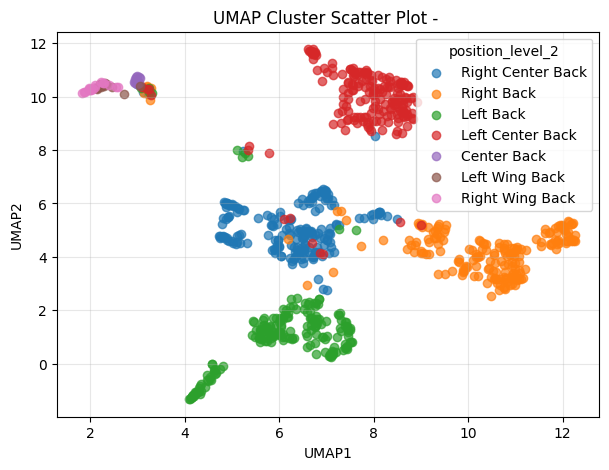

=== Automated selected features ===
Config 1 columns: 73
Config 2 columns: 58
Config 3 columns: 90
Final df shape: (2352, 90)


 99%|===================| 5745/5782 [02:15<00:00]        

(826, 86, 7)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


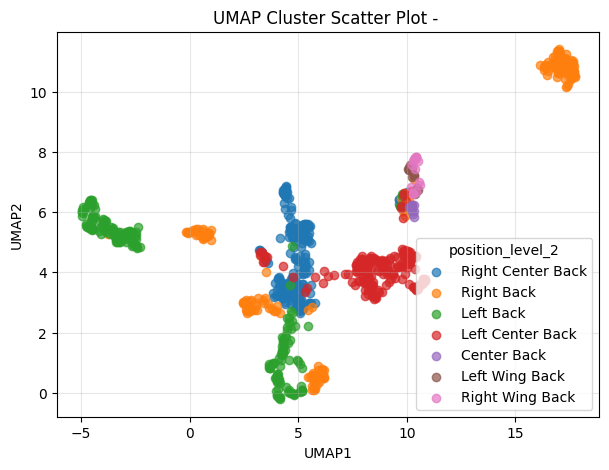

In [25]:
data_loading_functions = [get_manual_selected_features_data, get_data]
shap_df_dic = {}
include_heatmap = False

for load_data in data_loading_functions:
    # === Load and filter Data ===
    # load
    df = load_data(match_played=2, minutes_played=90)
    df = df.set_index("player_id")

    if include_heatmap:
        df = df.merge(
            df_heatmap[[c for c in df_heatmap.columns if "comp" in c]],
            left_on="player_id",
            right_index=True,
            how="left"
        )

    df_midfielder = df[df["position_level_0"] == "Defender"]
    df_midfielder = df_midfielder.fillna(0).reset_index(drop=True)

    # === Prepare X and y ===
    X = df_midfielder.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
    y = df_midfielder["position_level_2"]


    # Define pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),       # standardize features (mean=0, variance=1)
        ("clf",RandomForestClassifier(
                    n_estimators=200,    # more stable than 100
                    random_state=42,
                    n_jobs=-1))       # reduce dimensionality to 2 PCs
    ])
    pipe.fit(X, y)
    model = pipe.named_steps['clf']
    scaler = pipe.named_steps['scaler']


    # === SHAP ===
    # Create SHAP explainer
    X_scaled = scaler.transform(X)
    explainer = shap.Explainer(model, X_scaled) # would work: training data I provide X_scaled[:10]

    # Compute SHAP values for full data (disable additivity check)
    shap_values = explainer(X_scaled, check_additivity=False)
    print(shap_values.shape)

    # Step 1: Map position labels to class indices
    label_to_index = {label: idx for idx, label in enumerate(model.classes_)}  # e.g., {'Defender': 0, ...}
    true_class_indices = y.map(label_to_index).values  # shape: (3096,)
    
    # Step 2: Extract SHAP values of the true class for each sample
    # prepare shape and arrays for storage
    n_samples, n_features, n_classes = shap_values.values.shape
    shap_true_class = np.zeros((n_samples, n_features))
    n_samples, n_features, n_classes

    # for each player only consider shap embeddings of the actual true class
    for i in range(n_samples):
        shap_true_class[i] = shap_values.values[i, :, true_class_indices[i]] # (row, column, class)

    # Step 3: Convert to DataFrame
    shap_df = pd.DataFrame(shap_true_class, columns=shap_values.feature_names, index=df_midfielder.index)
    shap_df["position_level_0"] = df_midfielder["position_level_0"]
    shap_df["position_level_1"] = df_midfielder["position_level_1"]
    shap_df["position_level_2"] = df_midfielder["position_level_2"]
    shap_df_dic[load_data.__name__] = shap_df

    # === UMAP and Plot ===
    X_shap = shap_df.drop(columns=['position_level_0', "position_level_1", "position_level_2"])
    y_shap = shap_df['position_level_2']

    umap_transformer = UMAP(n_components=2, init='random', random_state=42)
    X_transformed = umap_transformer.fit_transform(X_shap)
    transformed_df = pd.DataFrame(X_transformed, columns=["UMAP1", "UMAP2"], index=df_midfielder.index)
    transformed_df["position_level_0"] = df_midfielder["position_level_0"]
    transformed_df["position_level_1"] = df_midfielder["position_level_1"]
    transformed_df["position_level_2"] = df_midfielder["position_level_2"]
    transformed_df["y"] = label_encoder.inverse_transform(y_encoded)


    # Plot 
    plot_umap_clusters(transformed_df, target="position_level_2")


# Wihtin Position: Plotting 2d UMAP + SHAP Label Encoded Models

In [45]:
df_standard_stats = pd.read_csv("../../data/new_approach/standard_stats_all_final.csv",dtype={"player_id":"int32"})
df_standard_stats["position_level_0"].value_counts()
df_standard_stats = df_standard_stats[df_standard_stats["position_level_0"] == "Midfielder"]

df_standard_stats["position_level_2"].value_counts()

position_level_2
Center Attacking Midfield    150
Right Defensive Midfield     130
Left Center Midfield         127
Left Defensive Midfield      122
Right Center Midfield        102
Center Defensive Midfield    100
Left Midfield                 99
Right Midfield                81
Left Attacking Midfield        2
Right Attacking Midfield       1
Name: count, dtype: int64

In [46]:
df_heatmap = pd.read_csv("../../data/new_approach/feature_multichannel_heatmap.csv")
df_heatmap = df_heatmap.set_index("player_id")
df_heatmap.head()

,player,player.1,new_position,role,shooting_comp_1,shooting_comp_2,shooting_comp_3,shooting_comp_4,shooting_comp_5,shooting_comp_6,...,possession_comp_5,possession_comp_6,passing_comp_1,passing_comp_2,passing_comp_3,passing_comp_4,passing_comp_5,passing_comp_6,goal_keeping_comp_1,position_level_1
player_id,,,,,,,,,,,,,,,,,,,,,
2936.0,Christophe Kerbrat,Christophe Kerbrat,Defender,Right Center Back,0.401860,-0.079829,0.157438,0.077106,-0.079946,0.008176,...,-0.054132,-0.043275,-0.006681,0.235279,0.213547,-0.052382,-0.132326,-0.020956,-0.075839,Regular Defender
2943.0,Lucas Deaux,Lucas Deaux,Midfielder,Right Wing,0.173943,-0.140731,-0.160445,0.048566,0.065537,-0.088838,...,-0.014248,-0.022420,-0.044679,-0.057008,0.138516,0.011638,0.063919,-0.015123,-0.075839,Winger
2944.0,Benjamin Corgnet,Benjamin Corgnet,Midfielder,Center Forward,0.124228,0.143748,-0.082011,-0.008427,-0.020652,0.011074,...,0.036347,0.014662,-0.076139,-0.028187,-0.120214,0.040950,0.013128,0.016054,-0.075839,Striker
2946.0,Frédéric Guilbert,Frédéric Guilbert,Defender,Right Back,-0.202061,-0.068776,-0.222270,0.031960,0.085961,0.088166,...,-0.038187,0.026946,-0.045397,0.280064,0.103629,-0.045295,-0.048134,0.017231,-0.075839,Offensive Defender
2947.0,Anthony Lopes,Anthony Lopes,Goalkeeper,Goalkeeper,-0.279010,-0.251161,-0.040615,-0.155556,-0.106620,-0.186720,...,-0.003719,0.010645,0.669226,-0.018354,-0.017189,-0.007102,0.012667,-0.004451,0.840877,Goalkeeper


=== Manual selected features ===
Number of selected manual selected features: 197
Loaded df shape: (2352, 197)
(17, 193, 5)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


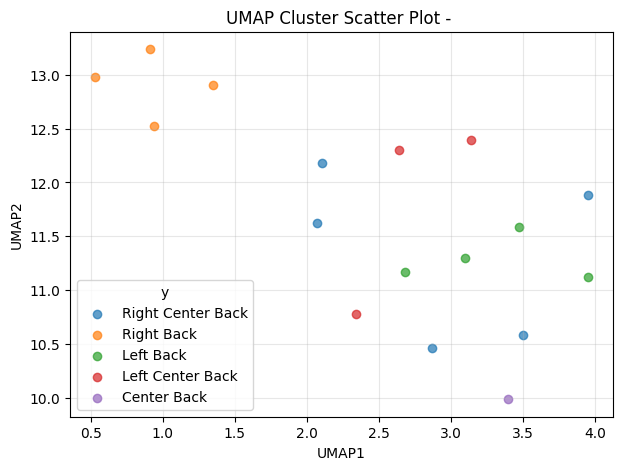

ARI: 0.320783711102574
NMI: 0.5988031622431886
=== Automated selected features ===
Config 1 columns: 73
Config 2 columns: 58
Config 3 columns: 90
Final df shape: (2352, 90)
(17, 86, 5)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


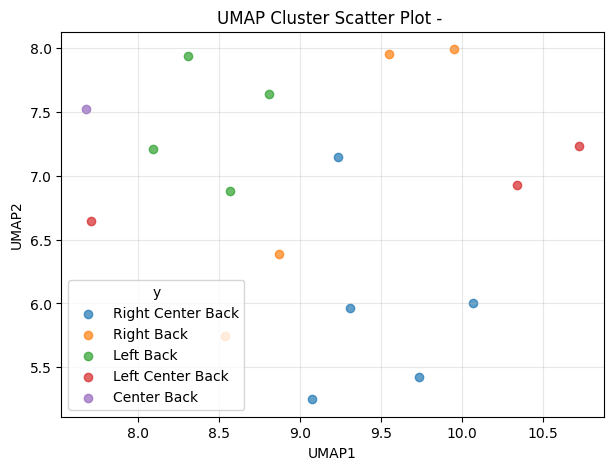

ARI: 0.2685363042643104
NMI: 0.5464091118058063


In [62]:
def plot_umap_clusters(transformed_df, target="position_level_0", name=""):
    plt.figure(figsize=(7, 5))
    plt.grid(True, alpha=0.3)
    # Plot each class separately for legend
    for label in transformed_df[target].unique():
        subset = transformed_df[transformed_df[target] == label]
        plt.scatter(subset["UMAP1"], subset["UMAP2"], label=label, alpha=0.7)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(f"UMAP Cluster Scatter Plot - {name}")
    plt.legend(title=target)
    plt.show()


data_loading_functions = [get_manual_selected_features_data, get_data]
shap_df_dic = {}
include_heatmap = False

for load_data in data_loading_functions:
    # === Load Fit Model ===
    # load
    df = load_data(match_played=2, minutes_played=90).head(50)
    df = df.set_index("player_id")

    if include_heatmap:
        df = df.merge(
            df_heatmap[[c for c in df_heatmap.columns if "comp" in c]],
            left_on="player_id",
            right_index=True,
            how="left"
        )

    df_midfielder = df[df["position_level_0"] == "Defender"]
    df_midfielder = df_midfielder.fillna(0).reset_index(drop=True)

    X = df_midfielder.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
    y = df_midfielder["position_level_2"]
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Define pipeline
    pipe = Pipeline([
        ("scaler", StandardScaler()),       # standardize features (mean=0, variance=1)
        ("pca", PCA()),
        ("clf", XGBClassifier(
                objective="multi:softprob",   # probabilities for multiclass
                eval_metric="mlogloss",       # stable multiclass metric
                n_estimators=200,             # 200 boosting rounds is plenty here
                max_depth=6,                  # balanced trees (not too deep for 2.5k samples)
                learning_rate=0.1,            # standard starting point
                subsample=0.8,                # random row sampling (prevents overfit)
                colsample_bytree=0.8,         # random feature sampling (helps with correlated features)
                reg_lambda=1.0,               # L2 regularization
                reg_alpha=0.5,                # L1 regularization (sparsity on weights)
                random_state=42,
                n_jobs=-1
            ))       # reduce dimensionality to 2 PCs
    ])
    pipe.fit(X, y_encoded)
    model = pipe.named_steps['clf']
    scaler = pipe.named_steps['scaler']

    # === SHAP ===
    # Create SHAP explainer
    X_scaled = scaler.transform(X)
    explainer = shap.Explainer(model, X_scaled) # would work: training data I provide X_scaled[:10]

    # Compute SHAP values for full data (disable additivity check)
    shap_values = explainer(X_scaled, check_additivity=False)
    print(shap_values.shape)

    # Step 1: Map position labels to class indices
    label_to_index = {label: idx for idx, label in enumerate(label_encoder.classes_)} # {label: idx for idx, label in enumerate(model.classes_)}  # e.g., {'Defender': 0, ...}
    true_class_indices = y.map(label_to_index).values  # shape: (3096,)
    
    # Step 2: Extract SHAP values of the true class for each sample
    # prepare shape and arrays for storage
    n_samples, n_features, n_classes = shap_values.values.shape
    shap_true_class = np.zeros((n_samples, n_features))
    n_samples, n_features, n_classes

    # for each player only consider shap embeddings of the actual true class
    for i in range(n_samples):
        shap_true_class[i] = shap_values.values[i, :, true_class_indices[i]] # (row, column, class)

    # Step 3: Convert to DataFrame
    shap_df = pd.DataFrame(shap_true_class, columns=shap_values.feature_names, index=df_midfielder.index)
    shap_df["position_level_0"] = df_midfielder["position_level_0"]
    shap_df["position_level_1"] = df_midfielder["position_level_1"]
    shap_df["position_level_2"] = df_midfielder["position_level_2"]
    shap_df_dic[load_data.__name__] = shap_df

    # === UMAP and Plot ===
    X_shap = shap_df.drop(columns=['position_level_0', "position_level_1", "position_level_2"])
    y_shap = shap_df['position_level_2']

    umap_transformer = UMAP(n_components=2, init='random', random_state=42)
    X_transformed = umap_transformer.fit_transform(X_shap)
    transformed_df = pd.DataFrame(X_transformed, columns=["UMAP1", "UMAP2"], index=df_midfielder.index)
    transformed_df["position_level_0"] = df_midfielder["position_level_0"]
    transformed_df["position_level_1"] = df_midfielder["position_level_1"]
    transformed_df["position_level_2"] = df_midfielder["position_level_2"]
    transformed_df["y"] = label_encoder.inverse_transform(y_encoded)


    # Plot 
    plot_umap_clusters(transformed_df, target="y")

    # evaluate cluster
    kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
    clusters = kmeans.fit_predict(X_transformed)
    print("ARI:", adjusted_rand_score(y, clusters))
    print("NMI:", normalized_mutual_info_score(y, clusters))


# Grid Search No Heatmap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from umap import UMAP
from xgboost import XGBClassifier
import shap

# ----------------------------
# 1) Register your experiment pipelines
#    Add as many as you want here.
# ----------------------------
EXPERIMENTS = {
    "PCA + XGB": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.5,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "No PCA + XGB": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.5,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "PCA + Random Forest" : Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "No PCA - Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ])
}

# ----------------------------
# 2) Tiny helpers
# ----------------------------
def attach_heatmap_if_needed(df, include_heatmap, df_heatmap):
    if not include_heatmap:
        return df
    return df.merge(
        df_heatmap[[c for c in df_heatmap.columns if "comp" in c]],
        left_on="player_id", right_index=True, how="left"
    )

def compute_shap_true_class(model, X_scaled, y_encoded, label_encoder):
    """
    Returns a (n_samples, n_features) array of SHAP values
    for the TRUE class of each sample.
    """
    explainer = shap.Explainer(model, X_scaled)
    shap_values = explainer(X_scaled, check_additivity=False)  # .values shape: (n, n_features, n_classes)
    n_samples, n_features, _ = shap_values.values.shape

    # Map encoded labels directly (they already match model classes_ order)
    shap_true = np.zeros((n_samples, n_features))
    for i in range(n_samples):
        shap_true[i] = shap_values.values[i, :, y_encoded[i]]

    return shap_true, shap_values.feature_names

def plot_umap_on_axis(ax, transformed_df, color_col="y", title_suffix=""):
    ax.grid(True, alpha=0.3)
    scatter_handles = []
    scatter_labels = []

    for label in transformed_df[color_col].unique():
        subset = transformed_df[transformed_df[color_col] == label]
        h = ax.scatter(subset["UMAP1"], subset["UMAP2"], label=label, alpha=0.7, s=18)
        scatter_handles.append(h)
        scatter_labels.append(label)

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_title(title_suffix)

    # Legend directly below the axis
    ax.legend(
        handles=scatter_handles,
        labels=scatter_labels,
        title="Position",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,           # spread across columns, adjust as needed
        frameon=False
    )

# ----------------------------
# 3) Core routine for ONE pipeline -> FOUR plots (one per position)
# ----------------------------
def run_pipeline_and_plot_row(
    load_data_fn,
    pipeline: Pipeline,
    exp_name: str,
    include_heatmap=False,
    df_heatmap=None,
    positions=("Defender", "Midfielder", "Forward"),
    sample_n=None,  # e.g. 50 to speed up
):
    # --- Load & prep base data (once) ---
    df = load_data_fn(match_played=2, minutes_played=90)
    if sample_n is not None:
        df = df.head(sample_n)
    df = df.set_index("player_id")
    df = attach_heatmap_if_needed(df, include_heatmap, df_heatmap)
    df = df.fillna(0)

    # --- Prepare figure with four axes ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
    handles_for_legend = None
    labels_for_legend = None

    for ax, pos in zip(axes, positions):
        # Subset by coarse position
        df_pos = df[df["position_level_0"] == pos].reset_index(drop=True)
        if df_pos.empty:
            ax.set_axis_off()
            ax.set_title(f"{pos} (no data)")
            continue

        # X/y & labels
        X = df_pos.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
        y = df_pos["position_level_2"]
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Fit the experiment pipeline
        pipeline.fit(X, y_encoded)
        scaler = pipeline.named_steps.get("scaler", None)
        model = pipeline.named_steps.get("clf", None)
        if scaler is None or model is None:
            raise ValueError("Pipeline must contain 'scaler' and 'clf' steps.")

        # SHAP for true class
        X_scaled = scaler.transform(X)
        shap_true, feature_names = compute_shap_true_class(model, X_scaled, y_encoded, le)

        # Build SHAP dataframe
        shap_df = pd.DataFrame(shap_true, columns=feature_names, index=df_pos.index)
        shap_df["position_level_0"] = df_pos["position_level_0"]
        shap_df["position_level_1"] = df_pos["position_level_1"]
        shap_df["position_level_2"] = df_pos["position_level_2"]
        shap_df["y"] = le.inverse_transform(y_encoded)

        # UMAP on SHAP space
        X_shap = shap_df.drop(columns=["position_level_0", "position_level_1", "position_level_2", "y"])
        umap = UMAP(n_components=2, init="random", random_state=42)
        X_emb = umap.fit_transform(X_shap)

        transformed_df = pd.DataFrame(X_emb, columns=["UMAP1", "UMAP2"], index=df_pos.index)
        transformed_df["y"] = shap_df["y"]  # color by fine position

        # Plot onto the axis
        plot_umap_on_axis(ax, transformed_df, color_col="y", title_suffix=f"{exp_name} · {pos}")

        # evaluate cluster
        kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
        clusters = kmeans.fit_predict(X_transformed)
        print("ARI:", adjusted_rand_score(y, clusters))
        print("NMI:", normalized_mutual_info_score(y, clusters))

        # Grab legend proxies from the first axis only
        if handles_for_legend is None:
            handles_for_legend, labels_for_legend = ax.get_legend_handles_labels()

    # Put one legend for the whole row on the right
    # if handles_for_legend:
    #     fig.legend(handles_for_legend, labels_for_legend, title="Fine position (y)", loc="center right", bbox_to_anchor=(1.02, 0.5))
    # fig.suptitle(f"UMAP (SHAP space) per coarse position — {exp_name}", y=1.02)
    return fig

# ----------------------------
# 4) Drive it for multiple experiments
# ----------------------------
def run_all_experiments(
    data_loading_functions,
    experiments_dict,
    include_heatmap=False,
    df_heatmap=None,
    positions=("Defender", "Midfielder", "Forward"),
    sample_n=50,
):
    for load_data_fn in data_loading_functions:
        for exp_name, pipe in experiments_dict.items():
            fig = run_pipeline_and_plot_row(
                load_data_fn=load_data_fn,
                pipeline=pipe,
                exp_name=f"{exp_name} | {load_data_fn.__name__}",
                include_heatmap=include_heatmap,
                df_heatmap=df_heatmap,
                positions=positions,
                sample_n=sample_n,
            )
            plt.show()

# ----------------------------
# 5) Example call
# ----------------------------
data_loading_functions = [get_manual_selected_features_data, get_data]
include_heatmap = False
run_all_experiments(
    data_loading_functions=data_loading_functions,
    experiments_dict=EXPERIMENTS,
    include_heatmap=False,   # or True if you provide df_heatmap
    df_heatmap=df_heatmap if include_heatmap else None,
    positions=("Defender", "Midfielder", "Forward"),
    sample_n=None
)


NameError: name 'include_heatmap' is not defined

# Grid Search Yes Heatmap

=== Manual selected features ===
Number of selected manual selected features: 197
Loaded df shape: (2352, 197)


 99%|===================| 5738/5782 [01:52<00:00]        c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
 99%|===================| 7119/7155 [03:04<00:00]        c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
 99%|===================| 2702/2735 [00:41<00:00]        c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


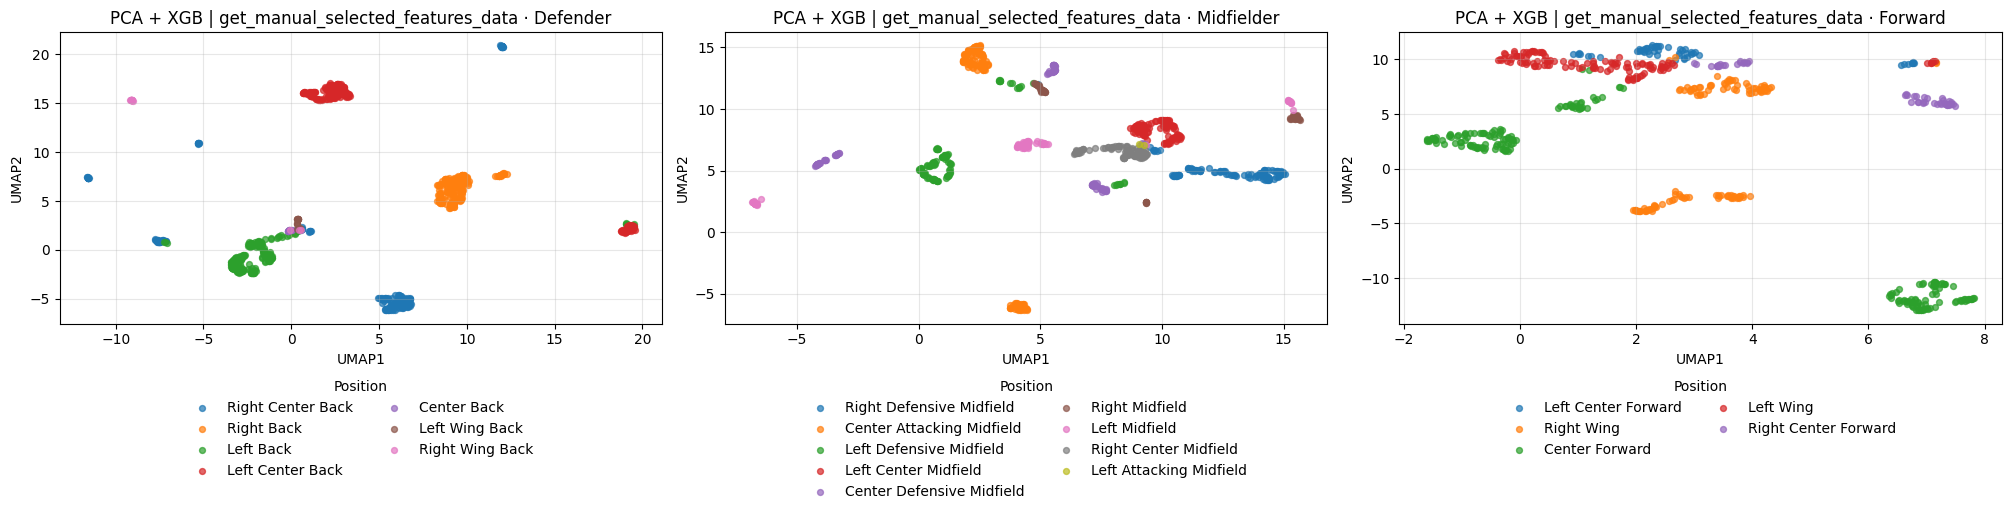

=== Automated selected features ===
Config 1 columns: 73
Config 2 columns: 58
Config 3 columns: 90
Final df shape: (2352, 90)


 64%|=============       | 3705/5782 [01:16<00:42]       

: 

: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from umap import UMAP
from xgboost import XGBClassifier
import shap

# ----------------------------
# 1) Register your experiment pipelines
#    Add as many as you want here.
# ----------------------------
EXPERIMENTS = {
    "PCA + XGB": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.5,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "No PCA + XGB": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            reg_alpha=0.5,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "PCA + Random Forest" : Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "No PCA - Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ])
}

# ----------------------------
# 2) Tiny helpers
# ----------------------------
def attach_heatmap_if_needed(df, include_heatmap, df_heatmap):
    if not include_heatmap:
        return df
    return df.merge(
        df_heatmap[[c for c in df_heatmap.columns if "comp" in c]],
        left_on="player_id", right_index=True, how="left"
    )

def compute_shap_true_class(model, X_scaled, y_encoded, label_encoder):
    """
    Returns a (n_samples, n_features) array of SHAP values
    for the TRUE class of each sample.
    """
    explainer = shap.Explainer(model, X_scaled)
    shap_values = explainer(X_scaled, check_additivity=False)  # .values shape: (n, n_features, n_classes)
    n_samples, n_features, _ = shap_values.values.shape

    # Map encoded labels directly (they already match model classes_ order)
    shap_true = np.zeros((n_samples, n_features))
    for i in range(n_samples):
        shap_true[i] = shap_values.values[i, :, y_encoded[i]]

    return shap_true, shap_values.feature_names

def plot_umap_on_axis(ax, transformed_df, color_col="y", title_suffix=""):
    ax.grid(True, alpha=0.3)
    scatter_handles = []
    scatter_labels = []

    for label in transformed_df[color_col].unique():
        subset = transformed_df[transformed_df[color_col] == label]
        h = ax.scatter(subset["UMAP1"], subset["UMAP2"], label=label, alpha=0.7, s=18)
        scatter_handles.append(h)
        scatter_labels.append(label)

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_title(title_suffix)

    # Legend directly below the axis
    ax.legend(
        handles=scatter_handles,
        labels=scatter_labels,
        title="Position",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,           # spread across columns, adjust as needed
        frameon=False
    )

# ----------------------------
# 3) Core routine for ONE pipeline -> FOUR plots (one per position)
# ----------------------------
def run_pipeline_and_plot_row(
    load_data_fn,
    pipeline: Pipeline,
    exp_name: str,
    include_heatmap=False,
    df_heatmap=None,
    positions=("Defender", "Midfielder", "Forward"),
    sample_n=None,  # e.g. 50 to speed up
):
    # --- Load & prep base data (once) ---
    df = load_data_fn(match_played=2, minutes_played=90)
    if sample_n is not None:
        df = df.head(sample_n)
    df = df.set_index("player_id")
    df = attach_heatmap_if_needed(df, include_heatmap, df_heatmap)
    df = df.fillna(0)

    # --- Prepare figure with four axes ---
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), constrained_layout=True)
    handles_for_legend = None
    labels_for_legend = None

    for ax, pos in zip(axes, positions):
        # Subset by coarse position
        df_pos = df[df["position_level_0"] == pos].reset_index(drop=True)
        if df_pos.empty:
            ax.set_axis_off()
            ax.set_title(f"{pos} (no data)")
            continue

        # X/y & labels
        X = df_pos.drop(columns=["position_level_0", "position_level_1", "position_level_2"])
        y = df_pos["position_level_2"]
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Fit the experiment pipeline
        pipeline.fit(X, y_encoded)
        scaler = pipeline.named_steps.get("scaler", None)
        model = pipeline.named_steps.get("clf", None)
        if scaler is None or model is None:
            raise ValueError("Pipeline must contain 'scaler' and 'clf' steps.")

        # SHAP for true class
        X_scaled = scaler.transform(X)
        shap_true, feature_names = compute_shap_true_class(model, X_scaled, y_encoded, le)

        # Build SHAP dataframe
        shap_df = pd.DataFrame(shap_true, columns=feature_names, index=df_pos.index)
        shap_df["position_level_0"] = df_pos["position_level_0"]
        shap_df["position_level_1"] = df_pos["position_level_1"]
        shap_df["position_level_2"] = df_pos["position_level_2"]
        shap_df["y"] = le.inverse_transform(y_encoded)

        # UMAP on SHAP space
        X_shap = shap_df.drop(columns=["position_level_0", "position_level_1", "position_level_2", "y"])
        umap = UMAP(n_components=2, init="random", random_state=42)
        X_emb = umap.fit_transform(X_shap)

        transformed_df = pd.DataFrame(X_emb, columns=["UMAP1", "UMAP2"], index=df_pos.index)
        transformed_df["y"] = shap_df["y"]  # color by fine position

        # Plot onto the axis
        plot_umap_on_axis(ax, transformed_df, color_col="y", title_suffix=f"{exp_name} · {pos}")

        # evaluate cluster
        kmeans = KMeans(n_clusters=len(set(y)), random_state=42)
        clusters = kmeans.fit_predict(X_transformed)
        print("ARI:", adjusted_rand_score(y, clusters))
        print("NMI:", normalized_mutual_info_score(y, clusters))

        # Grab legend proxies from the first axis only
        if handles_for_legend is None:
            handles_for_legend, labels_for_legend = ax.get_legend_handles_labels()

    # Put one legend for the whole row on the right
    # if handles_for_legend:
    #     fig.legend(handles_for_legend, labels_for_legend, title="Fine position (y)", loc="center right", bbox_to_anchor=(1.02, 0.5))
    # fig.suptitle(f"UMAP (SHAP space) per coarse position — {exp_name}", y=1.02)
    return fig

# ----------------------------
# 4) Drive it for multiple experiments
# ----------------------------
def run_all_experiments(
    data_loading_functions,
    experiments_dict,
    include_heatmap=False,
    df_heatmap=None,
    positions=("Defender", "Midfielder", "Forward"),
    sample_n=50,
):
    for load_data_fn in data_loading_functions:
        for exp_name, pipe in experiments_dict.items():
            fig = run_pipeline_and_plot_row(
                load_data_fn=load_data_fn,
                pipeline=pipe,
                exp_name=f"{exp_name} | {load_data_fn.__name__}",
                include_heatmap=include_heatmap,
                df_heatmap=df_heatmap,
                positions=positions,
                sample_n=sample_n,
            )
            plt.show()

# ----------------------------
# 5) Example call
# ----------------------------
df_heatmap = pd.read_csv("../../data/new_approach/feature_multichannel_heatmap.csv")
df_heatmap = df_heatmap.set_index("player_id")
include_heatmap = True

data_loading_functions = [get_manual_selected_features_data, get_data]
run_all_experiments(
    data_loading_functions=data_loading_functions,
    experiments_dict=EXPERIMENTS,
    include_heatmap=include_heatmap,   # or True if you provide df_heatmap
    df_heatmap=df_heatmap if include_heatmap else None,
    positions=("Defender", "Midfielder", "Forward"),
    sample_n=None
)
